# Evaluation on the Reconstruction Model (Vit Encoder + UpConv Decoder)

In [1]:
import torch
from torch.utils.data import DataLoader
from models.decoders import ReconstructionDecoder
from models.encoder import ViTEncoder
from data.datasets import ReconstructionDataset
import json

In [2]:
MODEL_PATH = './checkpoints/reconstruction.pth'
LOSS_PATH = './checkpoints/train_json/reconstruction_loss_data.json'
LOSS_PLOT = './checkpoints/train_images/recons.png'
DATA_PATH = '../ISIC2017_resized/'

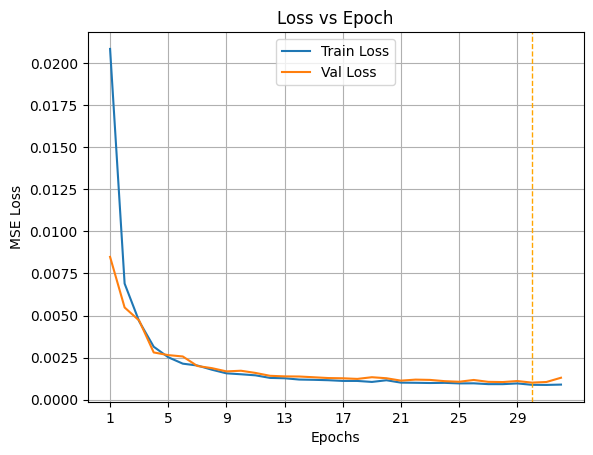

In [5]:
# Load the loss data
with open(LOSS_PATH, 'r') as f:
    loss_data = json.load(f)

# Show the loss curves
import matplotlib.pyplot as plt
plt.plot(loss_data['epoch'], loss_data['train_loss'], label='Train Loss')
plt.plot(loss_data['epoch'], loss_data['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.xticks(ticks=range(1, loss_data['epoch'][-1], 4))
plt.axvline(x=30, color='orange', linestyle='--', linewidth=1)
plt.savefig(LOSS_PLOT)

In [6]:
# Load the trained model
trained_model = torch.load(MODEL_PATH)
encoder = ViTEncoder()
decoder = ReconstructionDecoder()
encoder.load_state_dict(trained_model['encoder_state_dict'])
decoder.load_state_dict(trained_model['decoder_state_dict'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.to(device);
decoder.to(device);

In [7]:
test_loader = DataLoader(
    ReconstructionDataset(
        image_dir=DATA_PATH+"train_images/",
        transform=None,
        std=0.1,
    ),
    batch_size=5,
    shuffle=True,
)

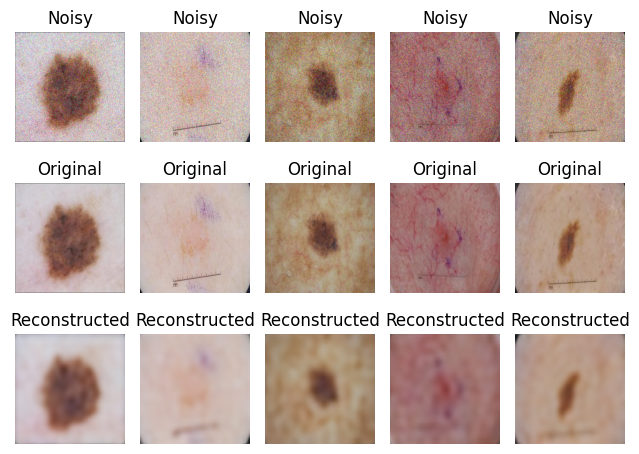

In [9]:
# Demonstrate on the test set
for noisy, clean in test_loader:
    noisy = noisy.to(device)
    clean = clean.to(device)
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        _, encoded = encoder(noisy)
        decoded = decoder(encoded)
    # Compare the 5 sets of noisy, original and reconstructed images
    noisy = noisy.cpu().numpy()
    clean = clean.cpu().numpy()
    decoded = decoded.cpu().numpy()
    noisy.transpose(0, 2, 3, 1)
    clean.transpose(0, 2, 3, 1)
    decoded.transpose(0, 2, 3, 1)
    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(noisy[i].transpose(1, 2, 0))
        plt.axis('off')
        plt.title('Noisy')
        plt.subplot(3, 5, i + 6)
        plt.imshow(clean[i].transpose(1, 2, 0))
        plt.axis('off')
        plt.title('Original')
        plt.subplot(3, 5, i + 11)
        plt.imshow(decoded[i].transpose(1, 2, 0))
        plt.axis('off')
        plt.title('Reconstructed')
    plt.tight_layout()
    break

In [ ]:
encoder_size = sum(p.numel() for p in encoder.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # float32 → MB
decoder_size = sum(p.numel() for p in decoder.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # float32 → MB
print(f"Encoder size: {encoder_size:.2f} MB")
print(f"Decoder size: {decoder_size:.2f} MB")

Encoder size: 327.30 MB
Decoder size: 19.42 MB
